# Unsupervised Clustering of Wound Border Features
This notebook performs dimensionality reduction and clustering on the extracted wound border features to identify patterns and group similar wounds.

## Loading Feature Vectors and Cleaning Dataset

In [97]:
## loading extracted feature vectors

import pandas as pd
import numpy as np
# load the full feature vectors csv
df = pd.read_csv("../outputs/wound_features_clean.csv")
print(f"Loaded {len(df)} feature rows")

#clean the dataset dropping rows with NaN values
df_clean = df.dropna()
features = df_clean.drop(columns=["image_id"]).values
print(f"{len(features)} rows remainign after dropping NaNs")


Loaded 1609 feature rows
1609 rows remainign after dropping NaNs


## Dimensionality Reduction for Visalization and Clustering with HDBSCAN

In [98]:
# Diamensionality reduction with PaCMAP
import pacmap

pmap = pacmap.PaCMAP(
    n_components=2,
    n_neighbors=None,     
    MN_ratio=5,
    FP_ratio=17,
    random_state=42,
    distance='euclidean'
)

embedding = pmap.fit_transform(features)

In [121]:
# Clustering using HDBSCAN
import hdbscan
#import numpy as np

# Cluster in reduced 2D space
clusterer = hdbscan.HDBSCAN(
    min_cluster_size= 20,
    min_samples=15,
    cluster_selection_epsilon=0.75,
    cluster_selection_method='eom',
    core_dist_n_jobs=-1,
    metric='euclidean'
)

labels = clusterer.fit_predict(embedding)

# Add to dataFrame
df_clean["cluster"] = labels
print(f"Found {len(set(labels)) - (1 if -1 in labels else 0)} clusters")

#unique, counts = np.unique(labels, return_counts=True)
#print("Cluster counts:", dict(zip(unique, counts)))

Found 6 clusters


/opt/anaconda3/envs/wound-pr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/wound-pr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


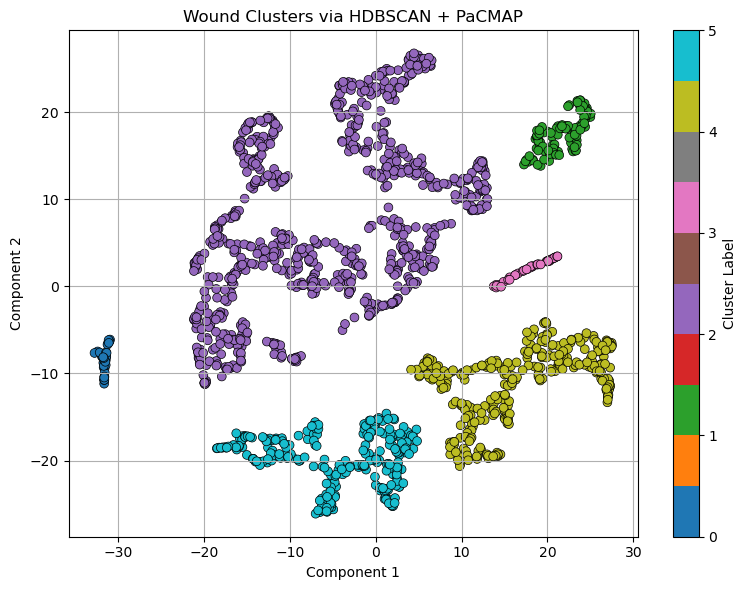

In [122]:
# visualize the clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="tab10", s=40, edgecolors='black', linewidths=0.5)
plt.title("Wound Clusters via HDBSCAN + PaCMAP")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster Label")
plt.grid(True)
plt.tight_layout()
plt.show()

## Saving Image Cluster Map

In [123]:
# Displaing Cluster Details: Number of samples in each cluster
import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(36), np.int64(1): np.int64(103), np.int64(2): np.int64(841), np.int64(3): np.int64(40), np.int64(4): np.int64(317), np.int64(5): np.int64(272)}


In [125]:
# Extract image IDs and their cluster assignments
image_clusters = df_clean[["image_id", "cluster"]]

# Save to a separate CSV
image_clusters.to_csv("../outputs/clusters/image_cluster_map.csv", index=False)

print("Saved cluster assignments to image_cluster_map.csv")

Saved cluster assignments to image_cluster_map.csv


## Preview Sample Images by Cluster


 Cluster 0 — Showing 3 sample(s)


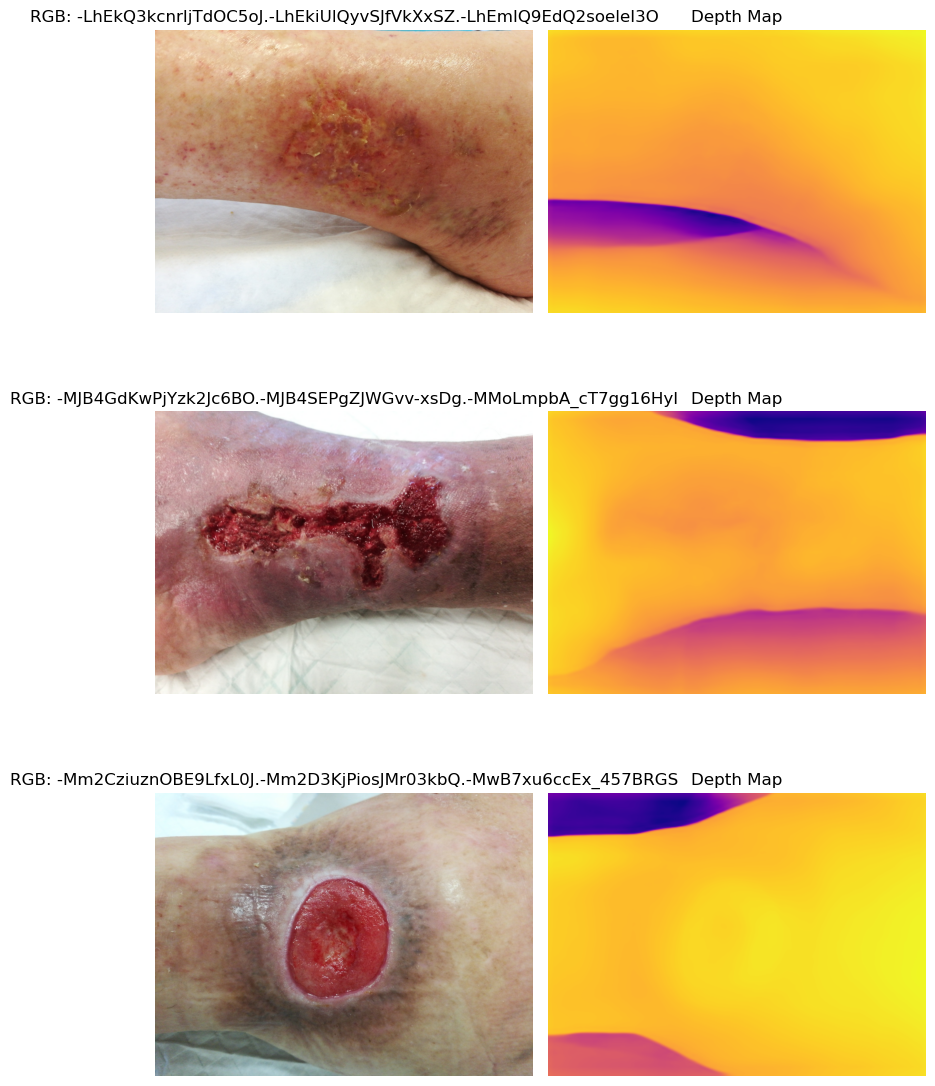


 Cluster 1 — Showing 3 sample(s)


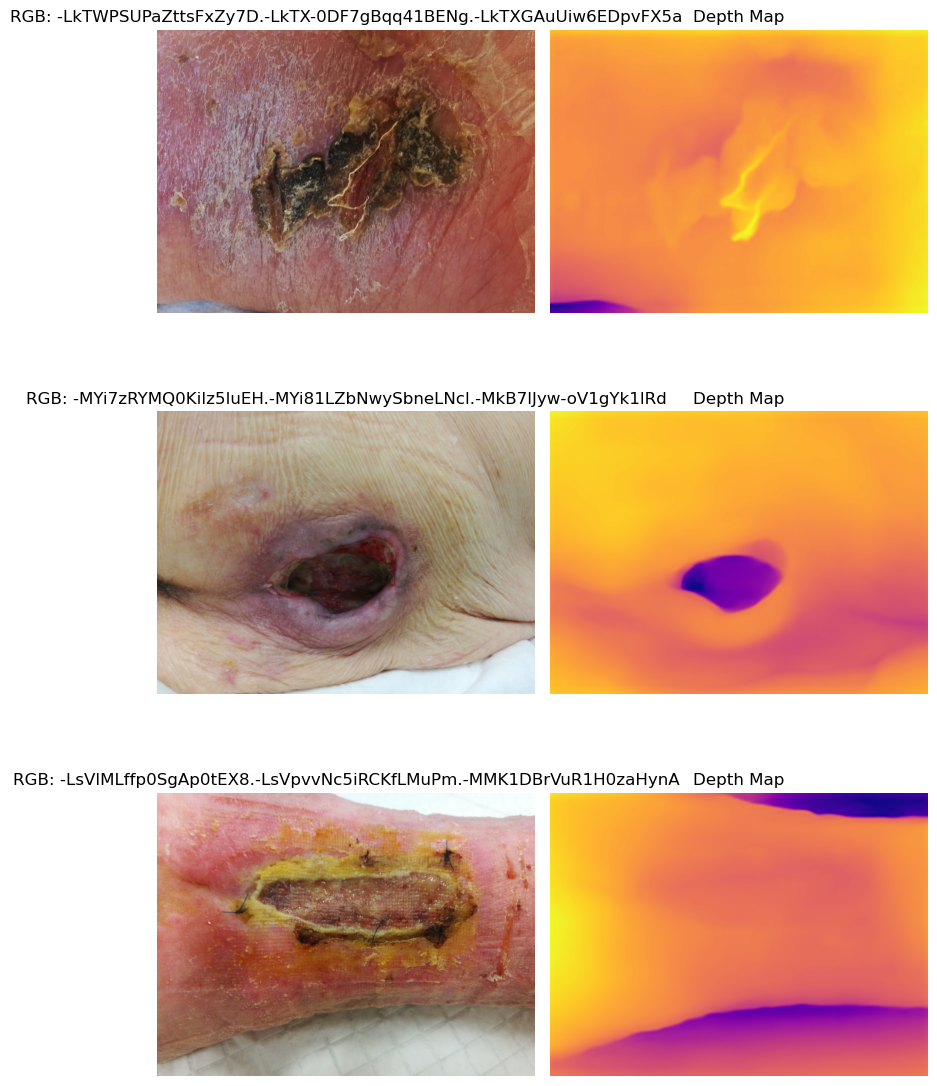


 Cluster 2 — Showing 3 sample(s)


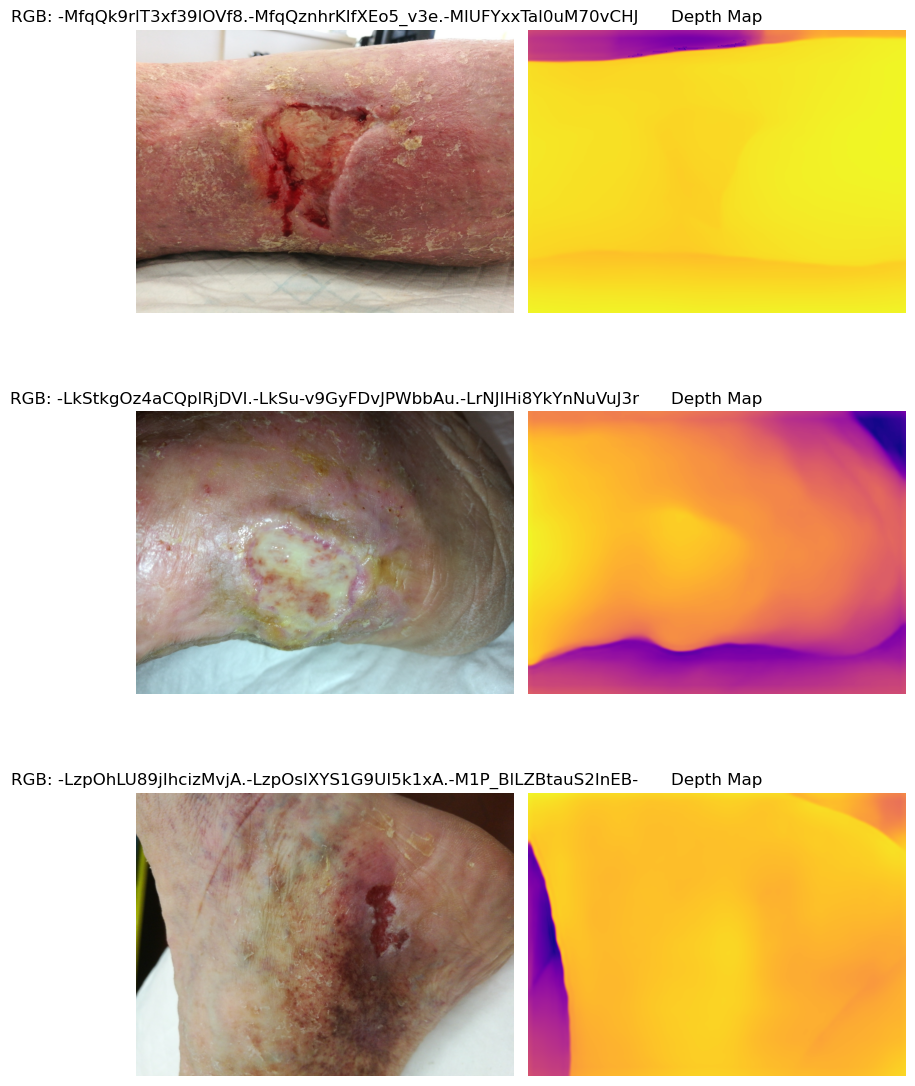


 Cluster 3 — Showing 3 sample(s)


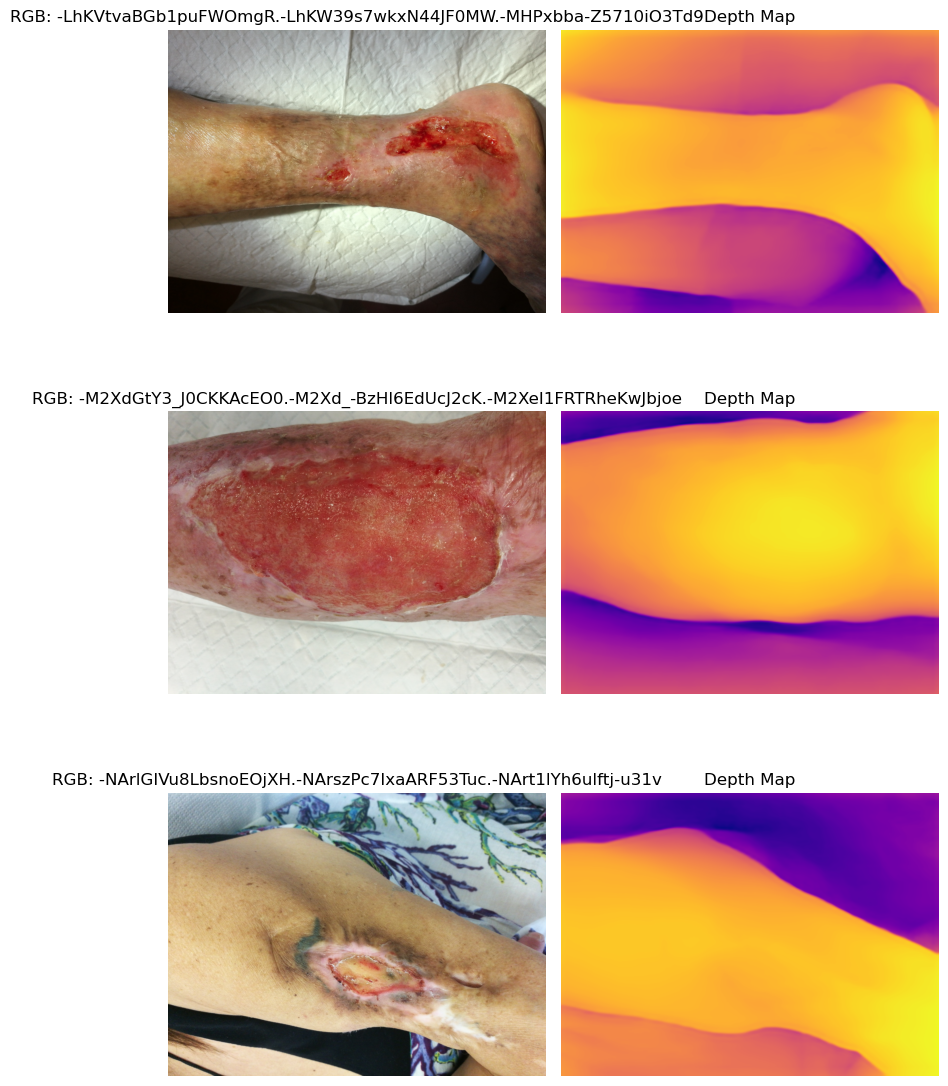


 Cluster 4 — Showing 3 sample(s)


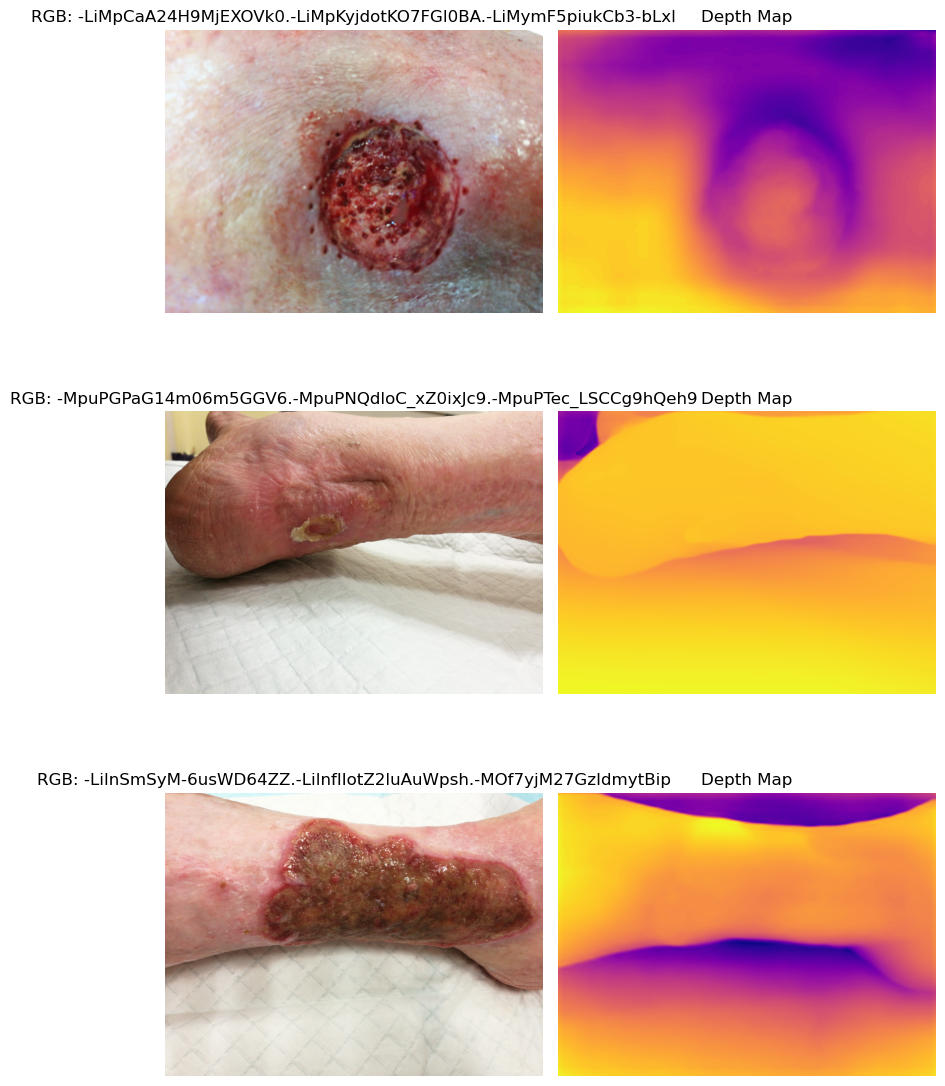


 Cluster 5 — Showing 3 sample(s)


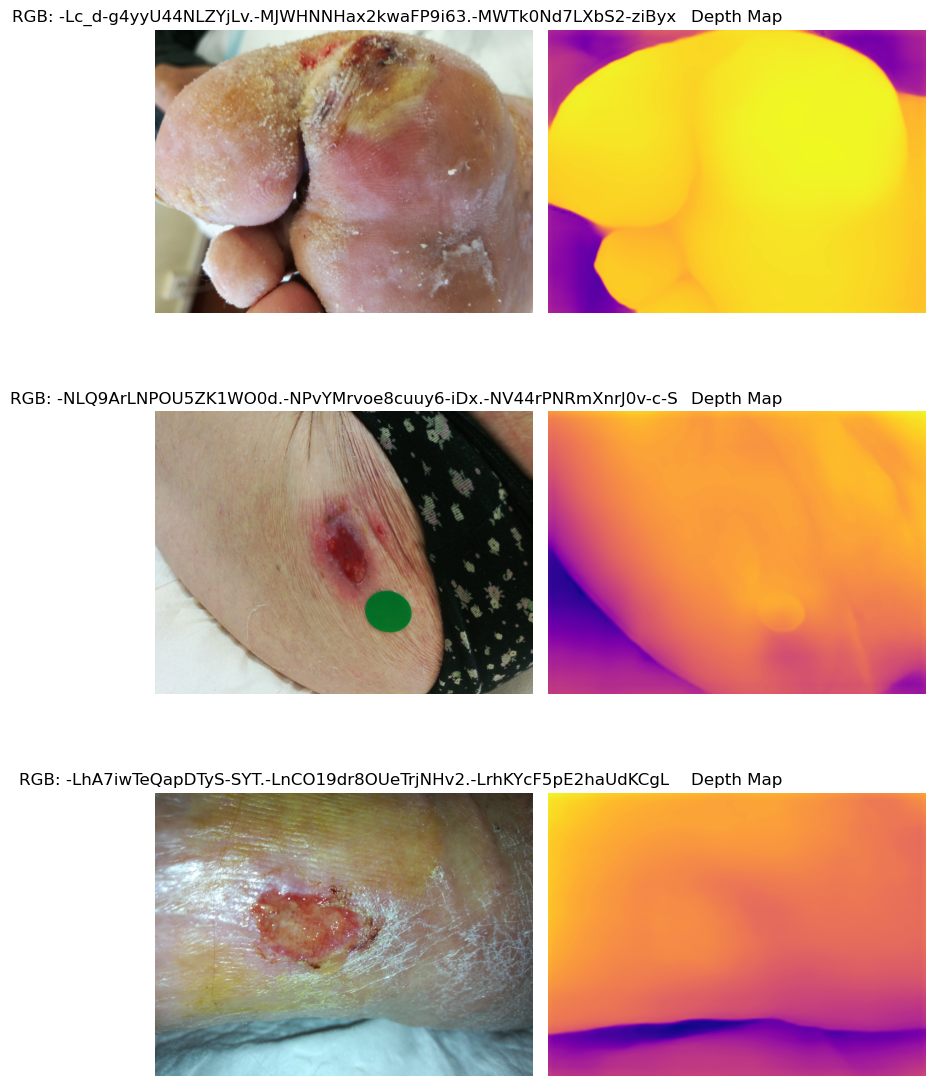

In [126]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load cluster mapping CSV
cluster_map = pd.read_csv("../outputs/clusters/image_cluster_map.csv")

# Group image IDs by cluster
cluster_groups = cluster_map.groupby("cluster")["image_id"].apply(list)

def preview_cluster_samples(cluster_id, sample_count=3, data_root="../../data"):
    print(f"\n Cluster {cluster_id} — Showing {sample_count} sample(s)")
    
    samples = cluster_groups.get(cluster_id, [])[:sample_count]
    if not samples:
        print("No samples available.")
        return

    fig, axs = plt.subplots(len(samples), 2, figsize=(8, 4 * len(samples)))

    if len(samples) == 1:
        axs = [axs]

    for i, name in enumerate(samples):
        rgb_path = os.path.join(data_root, "images", f"{name}.png")
        depth_path = os.path.join(data_root, "depth_maps", f"{name}.png")

        img = cv2.imread(rgb_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)

        axs[i][0].imshow(img)
        axs[i][0].set_title(f"RGB: {name}")
        axs[i][1].imshow(np.where(depth != 0, depth, np.nan), cmap="plasma_r")
        axs[i][1].set_title("Depth Map")

        for ax in axs[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

for cluster_id in sorted(cluster_groups.keys()):
    preview_cluster_samples(cluster_id, sample_count=3)

## Summary of Clusters

In [127]:
# Step 1: Get all cluster labels that were used
all_clusters = sorted(df_clean["cluster"].unique())

# Step 2: Calculate numeric summary
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
cluster_summary = df_clean.groupby("cluster")[numeric_cols].agg(['mean', 'std', 'count'])

# Step 3: Flatten column names
cluster_summary.columns = ['_'.join(col) for col in cluster_summary.columns]

# Step 4: Reindex to include missing clusters (like -1 or small ones)
cluster_summary = cluster_summary.reindex(all_clusters).reset_index()

# Step 5: Fill empty cells if needed
cluster_summary.fillna(np.nan, inplace=True)

# Final preview
print(cluster_summary)



   cluster  mean_mean  mean_std  mean_count  std_mean   std_std  std_count  \
0        0   0.005988  0.098372          36  2.283255  1.113448         36   
1        1   3.756501  4.863880         103  7.264522  5.323015        103   
2        2   1.436523  1.621423         841  2.200926  1.258646        841   
3        3  -0.114128  0.380115          40  3.868007  1.804774         40   
4        4  -1.679581  1.712199         317  3.663953  2.014674        317   
5        5  -0.890434  0.755831         272  1.506473  0.960714        272   

   min_mean   min_std  min_count  ...  fft_8_count   fft_9_mean    fft_9_std  \
0 -4.385175  2.285847         36  ...           36   244.122817   261.903966   
1 -9.661677  8.178773        103  ...          103  1248.622000  1280.506560   
2 -2.793711  2.555601        841  ...          841   178.365551   220.216987   
3 -7.980222  3.787789         40  ...           40   408.929313   318.623717   
4 -9.511121  5.328032        317  ...          317   

In [128]:
# Save the summary to a CSV file
cluster_summary.to_csv("../outputs/clusters/cluster_summary_stats.csv", index=False)
print("Cluster summary saved.")

Cluster summary saved.
